# 1.0. Install Dependencies and Setup

## 1.1 Install and Import

In [7]:
!pip install tensorflow opencv-python matplotlib

In [8]:
!pip install scikit-learn

In [9]:
!pip list

Package                       Version
----------------------------- ---------------
absl-py                       1.4.0
aiohttp                       3.8.3
aiosignal                     1.2.0
alabaster                     0.7.12
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.1
asttokens                     2.0.5
astunparse                    1.6.3
async-timeout                 4.0.2
atomicwrites                  1.4.0
attrs                         22.1.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.11.0
backcall                      0.2.0
bcrypt                        3.2.0
beautifulsoup4                4.12.2
binaryornot                   0.4.4
black                         0.0
bleach                        4.1.0
bokeh       

In [1]:
import tensorflow as tf
import os

In [2]:
#Only use 50% of GPU
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## 1.2. Remove Dodgy Image

In [3]:
import cv2
import imghdr # allows to check file extensions 
from matplotlib import pyplot as plt

In [64]:
data_dir = 'data' #variable to hold path to data directory

In [65]:
image_extensions = ['jpeg','jpg', 'bmp', 'png'] #list of standard image file extensions

In [66]:
# for loop - looping through directory and then every image to check if they can be used by cv2 and imghdr if not then they are removed
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path) #not a valid image
            tip = imghdr.what(image_path) #not a valid image extension
            
            if tip not in image_extensions: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [67]:
#How many classes are there?
num_classes = 0

#Iterate Directory
for path in os.listdir(data_dir):
    num_classes += 1
print ('File count:', num_classes)


File count: 2


# 2.0. Load Data

In [68]:
import numpy as np
from matplotlib import pyplot as plt

In [69]:
#Build the data pipeline
data = tf.keras.utils.image_dataset_from_directory('data') 

Found 4502 files belonging to 2 classes.


In [70]:
data_iterator = data.as_numpy_iterator() #access the generator from data pipeline - allowing us to loop through data pipeline

In [71]:
batch = data_iterator.next() #accessing the data piepline itself

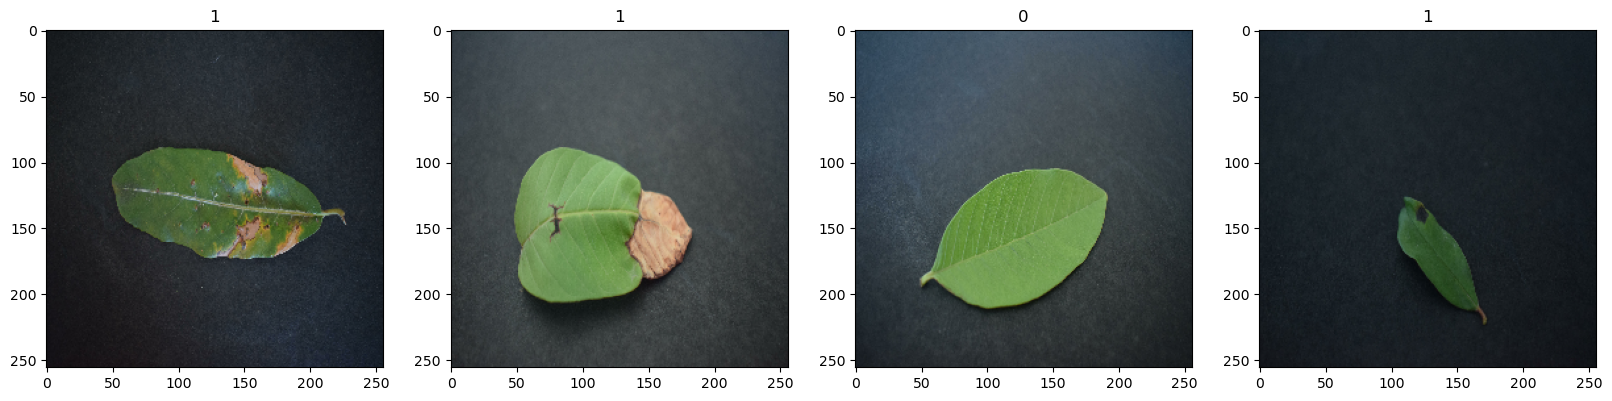

In [72]:
# for loop - looping through the images and classifying them as healthy = 0 and unhealthy = 1
#shows the classifications 0=healthy, 1 = unhealthy
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 3.0. Pre-Processing Data

## 3.1. Scale Data

In [73]:
data = data.map(lambda x,y: (x/255, y)) #map - applies a particular transformation as data is being preprocessed by the data pipeline... x = images, y = target values

In [74]:
scaled_iterator=data.as_numpy_iterator()

In [75]:
batch = scaled_iterator.next()

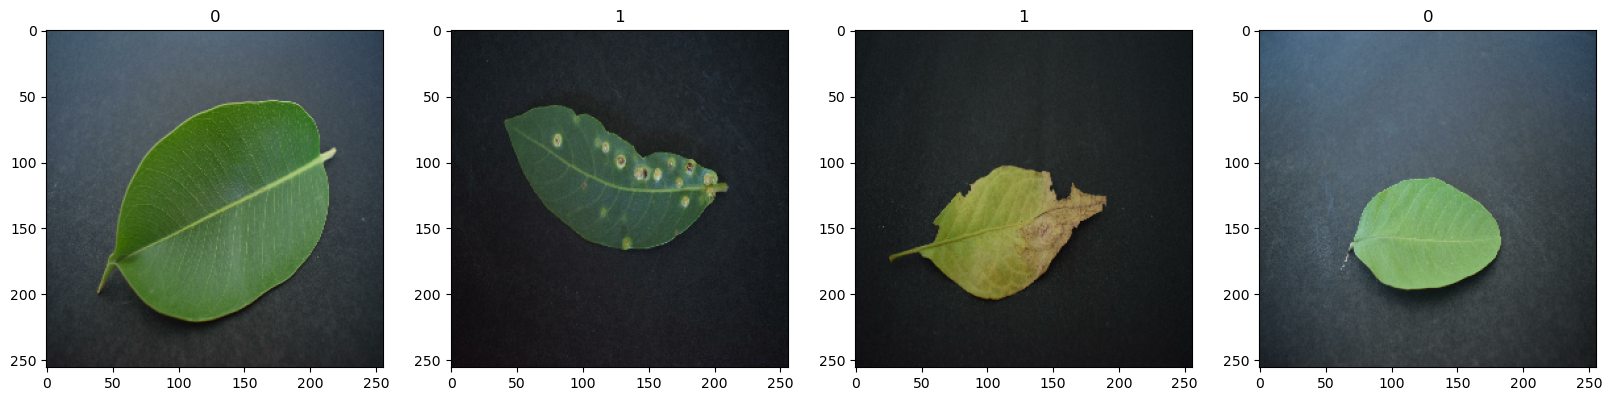

In [76]:
#CHECK IF IMAGES ARE LOADED AND SCALED
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])
    #shows the classifications healthy = 0 and unhealthy = 1

In [146]:
#CHECK FOR BATCH MAX AND MIN 0 - 1
#batch [0].min()
#batch [0].max()

0.90085787

## 3.2. Split Data

In [77]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [79]:
#Partitian Allocation
train_size = int(len(data)*.7) #training will be 70% of data
val_size = int(len(data)*.2) #20% for validation
test_size = int(len(data)*.1+1) #10% testing + 1 because the data is an uneven number

In [80]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [86]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=data_dir, target_size=(224,224), classes=['healthy', 'unhealthy'], batch_size=train_size)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=data_dir, target_size=(224,224), classes=['healthy', 'unhealthy'], batch_size=val_size)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=data_dir, target_size=(224,224), classes=['healthy', 'unhealthy'], batch_size=test_size, shuffle=False)

Found 4502 images belonging to 2 classes.
Found 4502 images belonging to 2 classes.
Found 4502 images belonging to 2 classes.


# 4.0. Deep Learning Model

## 4.1. Build SVN + CNN Model

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l2

In [44]:
model = Sequential()

In [45]:
#Adding layers sequestially
#16 = Number of filters
#3,3 = Size of filter
#1 Stride (one pixel and then moves onto the next pixel)
#activitation that gets applied - relu activation - taking the output from the convolution layer and passing it through the relu function - preserve the positive values - allows us to take into account the non linear values 
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D()) #condenses the data down

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu')) #fully connected layers

#Output layer
model.add(Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation
             ='linear'))

In [46]:
model.compile('adam', loss='squared_hinge', metrics=['accuracy'])

In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

## 4.2. Train

In [48]:
from tensorflow.keras.callbacks import TensorBoard

In [49]:
logdir='logs'

In [50]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=20, validation_data=val) #fit is the training function

## 4.3. Plot Performance

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 5.0 Evaluate

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test_batches.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [ ]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy: {acc.result().numpy()}')

# 6.0 Test

In [ ]:
import cv2
from matplotlib import pyplot as plt

In [ ]:
img = cv2.imread('healthy_test.jpg')
plt.imshow(img)
plt.show()

In [ ]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))

In [ ]:
yhat

In [ ]:
if yhat > 0.5: 
    print(f'Predicted class is Unhealthy')
else:
    print(f'Predicted class is Healthy')

In [ ]:
test_labels = []
test_samples = []

# 7.0 Confusion Matrix

## 7.1 Prepare Data

In [159]:
#Import necessary libraries
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [160]:
train_imgs, train_labels = train_batches.next()
test_imgs, test_labels = test_batches.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

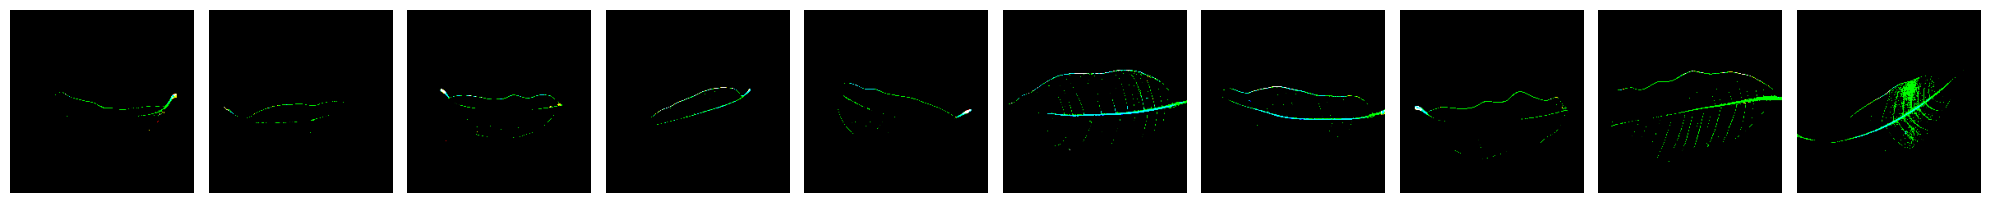

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [161]:
plotImages(test_imgs)
print(test_labels)

## 7.2 Predicting on the Test Data

In [163]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

InvalidArgumentError: Graph execution error:

Detected at node 'sequential/dense/Relu' defined at (most recent call last):
    File "C:\Users\roxan\anaconda3\envs\classification\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\roxan\anaconda3\envs\classification\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\roxan\anaconda3\envs\classification\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\roxan\anaconda3\envs\classification\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\roxan\anaconda3\envs\classification\lib\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "C:\Users\roxan\anaconda3\envs\classification\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\roxan\anaconda3\envs\classification\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Users\roxan\anaconda3\envs\classification\lib\asyncio\base_events.py", line 1906, in _run_once
      handle._run()
    File "C:\Users\roxan\anaconda3\envs\classification\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\roxan\anaconda3\envs\classification\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\roxan\anaconda3\envs\classification\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\roxan\anaconda3\envs\classification\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\roxan\anaconda3\envs\classification\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\roxan\anaconda3\envs\classification\lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "C:\Users\roxan\anaconda3\envs\classification\lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\roxan\anaconda3\envs\classification\lib\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "C:\Users\roxan\anaconda3\envs\classification\lib\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "C:\Users\roxan\anaconda3\envs\classification\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\roxan\anaconda3\envs\classification\lib\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\roxan\anaconda3\envs\classification\lib\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\roxan\anaconda3\envs\classification\lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\roxan\AppData\Local\Temp\ipykernel_20616\121069103.py", line 1, in <module>
      predictions = model.predict(x = test_batches, verbose=0)
    File "C:\Users\roxan\anaconda3\envs\classification\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\roxan\anaconda3\envs\classification\lib\site-packages\keras\engine\training.py", line 2382, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "C:\Users\roxan\anaconda3\envs\classification\lib\site-packages\keras\engine\training.py", line 2169, in predict_function
      return step_function(self, iterator)
    File "C:\Users\roxan\anaconda3\envs\classification\lib\site-packages\keras\engine\training.py", line 2155, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\roxan\anaconda3\envs\classification\lib\site-packages\keras\engine\training.py", line 2143, in run_step
      outputs = model.predict_step(data)
    File "C:\Users\roxan\anaconda3\envs\classification\lib\site-packages\keras\engine\training.py", line 2111, in predict_step
      return self(x, training=False)
    File "C:\Users\roxan\anaconda3\envs\classification\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\roxan\anaconda3\envs\classification\lib\site-packages\keras\engine\training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\roxan\anaconda3\envs\classification\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\roxan\anaconda3\envs\classification\lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\roxan\anaconda3\envs\classification\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\roxan\anaconda3\envs\classification\lib\site-packages\keras\engine\sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\roxan\anaconda3\envs\classification\lib\site-packages\keras\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\roxan\anaconda3\envs\classification\lib\site-packages\keras\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\roxan\anaconda3\envs\classification\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\roxan\anaconda3\envs\classification\lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\roxan\anaconda3\envs\classification\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\roxan\anaconda3\envs\classification\lib\site-packages\keras\layers\core\dense.py", line 255, in call
      outputs = self.activation(outputs)
    File "C:\Users\roxan\anaconda3\envs\classification\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "C:\Users\roxan\anaconda3\envs\classification\lib\site-packages\keras\backend.py", line 5396, in relu
      x = tf.nn.relu(x)
Node: 'sequential/dense/Relu'
Matrix size-incompatible: In[0]: [15,10816], In[1]: [14400,256]
	 [[{{node sequential/dense/Relu}}]] [Op:__inference_predict_function_2053]

# 8.0 Data Augmentation

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
    channel_shift_range=10., horizontal_flip=True)

In [ ]:
chosen_image = random.choice(os.listdir('data/unhealthy-vs-healthy/train/unhealthy'))

In [ ]:
image_path = 'data/unhealthy-vs-healthy/train/unhealthy' + chosen_image

In [ ]:
image = np.expand_dims(plt.imread(image_path),0)
plt.imshow(image[0])

In [ ]:
aug_iter = gen.flow(image)
aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]

In [ ]:
plotImages(aug_images)

In [ ]:
aug_iter = gen.flow(image, save_to_dir='data/unhealthy-vs-healthy/train/unhealthy', save_prefix='aug-image-', save_format='jpeg')

# 9.0 Save Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models','leafhealth.h5'))

In [ ]:
new_model = load_model('leafhealth.h5')

In [ ]:
new_model.predict(np.expand_dims(resize/255, 0))